---
title: "Corona"
format:
  html:
    code-fold: true
    code-summary: "Show the code"
---

In [1]:
import os
import pandas as pd
import numpy as np
import textwrap
import matplotlib.pyplot as plt
from module1_s4_functions import *
import numpy.typing as npt
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from scipy.stats import gmean
import matplotlib.dates as mdates

In [2]:
pd.set_option("display.float_format", "{:.3g}".format)
base_fig_wid = 9  # base width of a figure
base_font_size = 12  # base size of a font
dpi = 96
plt.rcParams["font.size"] = base_font_size

Putting the data from separate in .csv files into a dictionary of pandas dataframes

In [3]:
data_files = csv_files = [f for f in os.listdir("data") if f.endswith(".csv")]
data = {}
for file in csv_files:
    file_path = os.path.join("data/", file)
    df = pd.read_csv(file_path)
    data[file[:-4]] = df

1. The Lists of Data Table
1) Case Data
Case: Data of COVID-19 infection cases in South Korea
2) Patient Data
PatientInfo: Epidemiological data of COVID-19 patients in South Korea
PatientRoute: Route data of COVID-19 patients in South Korea (currently unavailable)
3) Time Series Data
Time: Time series data of COVID-19 status in South Korea
TimeAge: Time series data of COVID-19 status in terms of the age in South Korea
TimeGender: Time series data of COVID-19 status in terms of gender in South Korea
TimeProvince: Time series data of COVID-19 status in terms of the Province in South Korea
4) Additional Data
Region: Location and statistical data of the regions in South Korea
Weather: Data of the weather in the regions of South Korea
SearchTrend: Trend data of the keywords searched in NAVER which is one of the largest portals in South Korea
SeoulFloating: Data of floating population in Seoul, South Korea (from SK Telecom Big Data Hub)
Policy: Data of the government policy for COVID-19 in South Korea

### Time series of total infections

Formatting the date data:

In [4]:

data['Time']['date'] = pd.to_datetime(data['Time']['date'])
data['Time'].set_index('date',inplace=True)
data['Time']

,time,test,negative,confirmed,released,deceased
date,,,,,,
2020-01-20,16,1,0,1,0,0
2020-01-21,16,1,0,1,0,0
2020-01-22,16,4,3,1,0,0
2020-01-23,16,22,21,1,0,0
2020-01-24,16,27,25,2,0,0
...,...,...,...,...,...,...
2020-06-26,0,1232315,1200885,12602,11172,282
2020-06-27,0,1243780,1211261,12653,11317,282
2020-06-28,0,1251695,1219975,12715,11364,282


Adding a new cases column:

In [5]:
data['Time']['new_cases'] = data['Time']['confirmed'] - data['Time']['confirmed'].shift(1)

In [6]:
data['Time']

,time,test,negative,confirmed,released,deceased,new_cases
date,,,,,,,
2020-01-20,16,1,0,1,0,0,NaN
2020-01-21,16,1,0,1,0,0,0
2020-01-22,16,4,3,1,0,0,0
2020-01-23,16,22,21,1,0,0,0
2020-01-24,16,27,25,2,0,0,1
...,...,...,...,...,...,...,...
2020-06-26,0,1232315,1200885,12602,11172,282,39
2020-06-27,0,1243780,1211261,12653,11317,282,51
2020-06-28,0,1251695,1219975,12715,11364,282,62


Creating a two day doubling line:

In [7]:
# Create an array of dates starting from the start date
dates = pd.date_range(start='2020-01-20', end='2020-06-30', freq='2D')

# Create an array of confirmed cases that doubles every two days
confirmed_cases = np.power(2, np.arange(len(dates) // 2 + 1))
confirmed_cases = np.tile(confirmed_cases, 2)[:len(dates)]

# Create an array of new cases for each date
new_cases = np.zeros(len(dates))
new_cases[0] = confirmed_cases[0]
# Create a DataFrame with the date, confirmed, and new cases columns
doubling_line = pd.DataFrame({'date': dates, 'confirmed': confirmed_cases})
doubling_line['new_cases'] = doubling_line['confirmed'] - doubling_line['confirmed'].shift(1).fillna(0)

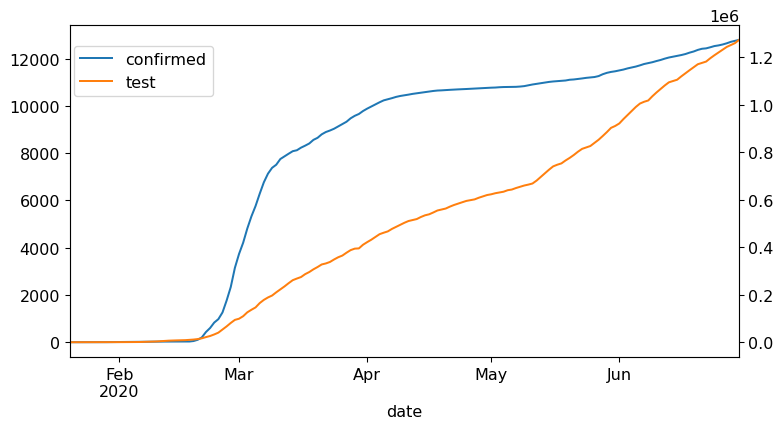

In [9]:
# | label: fig-time-total
# | fig-cap: "Time series of total cases"
fig_time_total, ax_time_total_conf = plt.subplots(
    figsize=(base_fig_wid, base_fig_wid / 2), dpi=96
)
ax_time_total_tests = ax_time_total_conf.twinx()
# plots
data["Time"].plot(
    y=["confirmed", "test"],
    ax=[ax_time_total_conf, ax_time_total_tests],
    subplots=True,
    legend=False
)
# Axes
ax_time_total_conf.xaxis.set_major_locator(mdates.MonthLocator())
ax_time_total_conf.minorticks_off()


# data["Time"].plot(x="date", y="test",ax=ax_time_total_tests)
fig_time_total.legend(bbox_to_anchor=(0.3,0.85))

plt.show()

Summing the data by week

In [17]:
weekly_time=data['Time'].resample('W').last()
weekly_time['new_cases'] = weekly_time['confirmed'] - weekly_time['confirmed'].shift(1).fillna(0)
weekly_time

,time,test,negative,confirmed,released,deceased,new_cases
date,,,,,,,
2020-01-26,16,51,47,3,0,0,3
2020-02-02,16,429,327,15,0,0,12
2020-02-09,16,2598,1683,27,3,0,12
2020-02-16,16,8161,7647,29,9,0,2
2020-02-23,16,26179,17520,602,18,6,573
2020-03-01,16,98921,61825,3736,30,18,3.13e+03
2020-03-08,0,188518,162008,7134,130,50,3.4e+03
2020-03-15,0,268212,243778,8126,834,75,992
2020-03-22,0,331780,308343,8897,2909,104,771


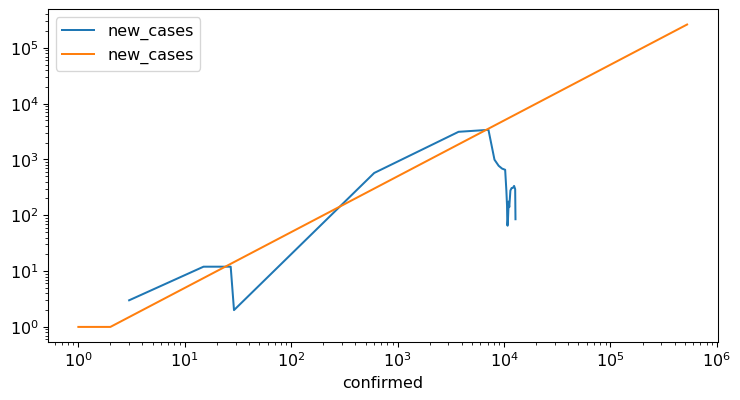

In [19]:
fig_trends,ax_trends=plt.subplots(figsize=(base_fig_wid, base_fig_wid / 2), dpi=96)
weekly_time.plot(x='confirmed',y='new_cases',ax=ax_trends)
doubling_line[:20].plot(x='confirmed',y='new_cases',ax=ax_trends)
ax_trends.set_yscale('log')
ax_trends.set_xscale('log')


In [ ]:
doubling_line


,date,confirmed,new_cases
0,2020-01-20,1,1
1,2020-01-22,2,1
2,2020-01-24,4,2
3,2020-01-26,8,4
4,2020-01-28,16,8
...,...,...,...
77,2020-06-22,34359738368,1.72e+10
78,2020-06-24,68719476736,3.44e+10
79,2020-06-26,137438953472,6.87e+10
80,2020-06-28,274877906944,1.37e+11
